# BOOSTING

data : adult.csv  
target : income  
preprocess:  
- missing value : simple imputer with constant
- one hot encoding : relationship, race, sex
- binary encoding : workclass, marital status, occupation, native country  
- ordinal encoding : education (already encoded)
- no treatment : numerical
- out : fnlwgt


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [16]:
df_adult = pd.read_csv('adult.csv')
df_adult.head(3)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K


In [17]:
df_adult.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [18]:
# ubah ? jadi np.nan
df_adult = df_adult.replace('?', np.nan)

In [19]:
df_adult.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [20]:
df_adult.isna().sum()/df_adult.shape[0]*100

age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64

In [21]:
# loadingnya lama !!!!!

# melihat null 
# plt.figure(figsize=(20,20))
# sns.heatmap(df_adult[['workclass','occupation','native.country']].isnull())

# Preprocessing

preprocess scheme:
* one hot encoding : relationship, race, sex
* binary encoding : workclass, marital status, occupation, native country  
* ordinal encoding : education (already encoded)
* no treatment : size

drop: fnlwgt


isi missing value: constant NC




In [42]:
# pipeline berisi imputing lalu binary encoding untuk 'embark_town' nanti
binary_encoder_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='NC')),
    ('binary encoder', ce.BinaryEncoder())
])

# transformer 
transformer = ColumnTransformer([
    ('one hot encoder', OneHotEncoder(drop='first'), ['relationship','race','sex']),
    ('binary encoder', binary_encoder_pipeline, ['workclass','marital.status','occupation','native.country'])
], remainder='passthrough')

In [43]:
X = df_adult.drop(columns=['fnlwgt','income','education'])
y = np.where(df_adult['income']=='>50K',1,0)

In [44]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    stratify = y, 
    random_state = 10)

In [45]:
X_train_val_preprocessed = transformer.fit_transform(X_train_val)
X_test_preprocessed = transformer.fit_transform(X_test)

In [46]:
X_train_val_preprocessed = pd.DataFrame(X_train_val_preprocessed)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed)

In [47]:
features = list(transformer.transformers_[0][1].get_feature_names()) + transformer.transformers_[1][1]['binary encoder'].get_feature_names() + ['age','education.num','capital.gain','capital.loss','hours.per.week']
X_train_val_preprocessed.columns = features
X_test_preprocessed.columns = features
X_train_val_preprocessed


,x0_Not-in-family,x0_Other-relative,x0_Own-child,x0_Unmarried,x0_Wife,x1_Asian-Pac-Islander,x1_Black,x1_Other,x1_White,x2_Male,...,3_2,3_3,3_4,3_5,3_6,age,education.num,capital.gain,capital.loss,hours.per.week
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,63.0,9.0,0.0,0.0,40.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,47.0,13.0,0.0,0.0,40.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,90.0,4.0,0.0,0.0,40.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,64.0,9.0,7298.0,0.0,45.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,33.0,13.0,0.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24415,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,25.0,10.0,0.0,0.0,35.0
24416,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,51.0,15.0,3325.0,0.0,40.0
24417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,60.0,11.0,0.0,0.0,40.0
24418,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,23.0,10.0,0.0,0.0,30.0


# Model Evaluation

In [48]:
model = DecisionTreeClassifier(max_depth=3)

model.fit(X_train_val_prepocessed, y_train_val)

y_pred = model.predict(X_test_prepocessed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6181
           1       0.74      0.51      0.60      1960

    accuracy                           0.84      8141
   macro avg       0.80      0.73      0.75      8141
weighted avg       0.83      0.84      0.83      8141



In [49]:
# impotance table

In [55]:
importance_table = pd.DataFrame({
    'imp':model.feature_importances_
}, index=features)

importance_table

,imp
x0_Not-in-family,0.000000
x0_Other-relative,0.000000
x0_Own-child,0.000000
x0_Unmarried,0.000000
x0_Wife,0.000000
x1_Asian-Pac-Islander,0.000000
x1_Black,0.000000
x1_Other,0.000000
x1_White,0.000000
x2_Male,0.000000


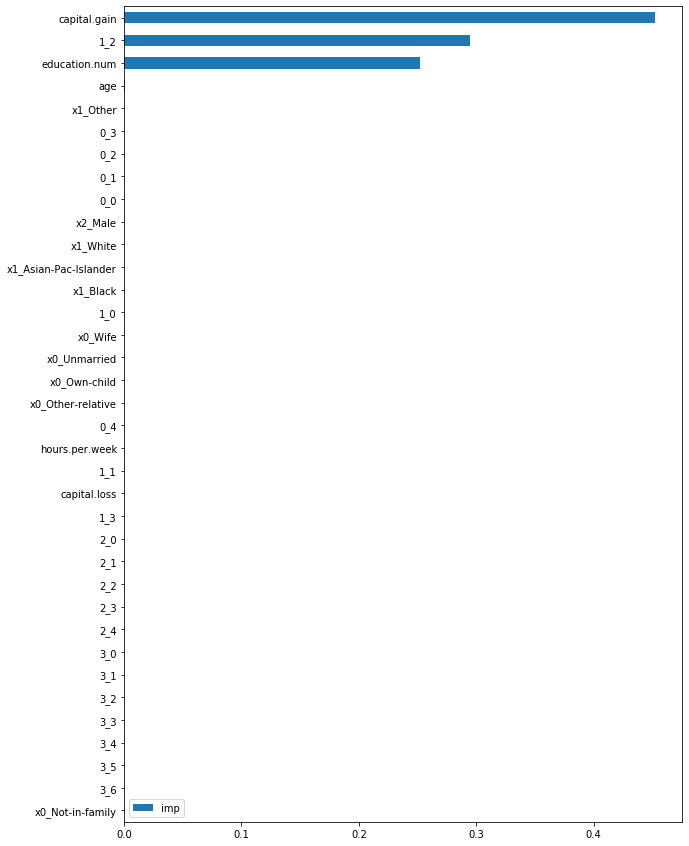

In [65]:
importance_table.sort_values(by='imp').plot(kind='barh', figsize=(10,15))

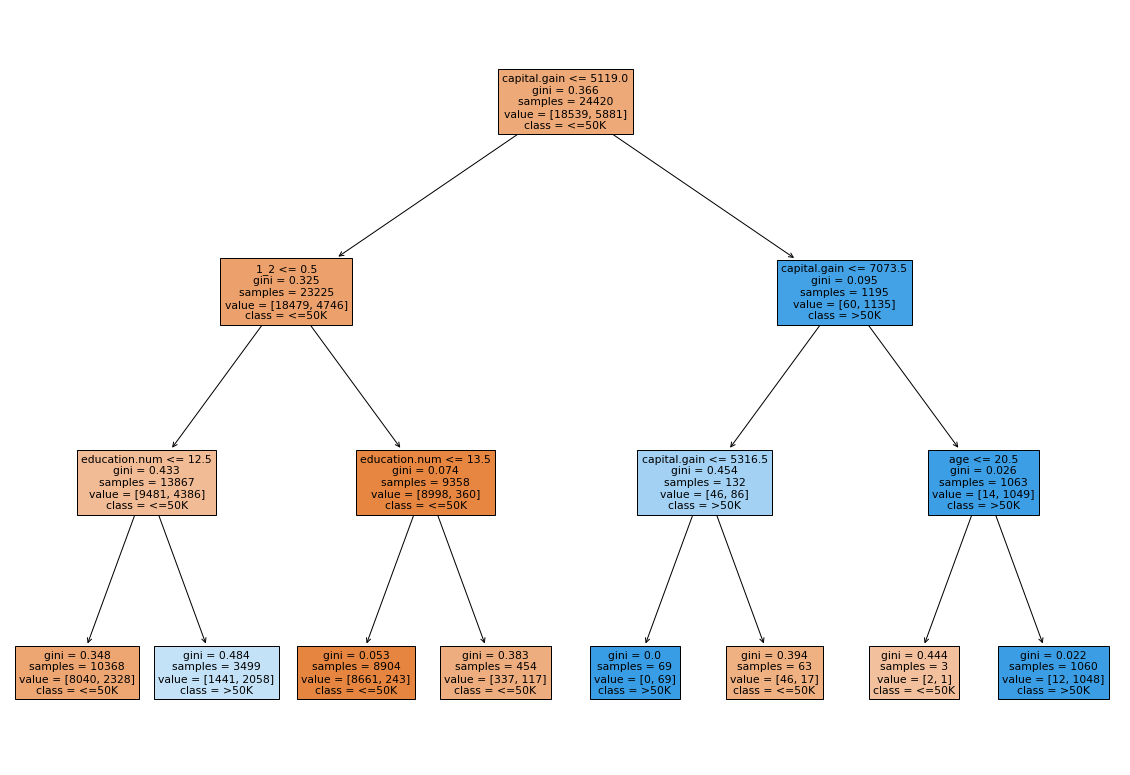

In [56]:
plt.figure(figsize=(20,14))
plot_tree(model, feature_names=features, filled=True, class_names=['<=50K','>50K'])
plt.show()

# Adaptive Boosting

In [57]:
# Adaptive Boosting
tree = DecisionTreeClassifier(max_depth=3)
model = AdaBoostClassifier(
    tree,
    n_estimators=200,
    learning_rate=0.1,
    random_state=10 
)

model.fit(X_train_val_prepocessed, y_train_val)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=200, random_state=10)

In [59]:
y_pred = model.predict(X_test_preprocessed)
print('Classification Report: \n', classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      6181
           1       0.77      0.55      0.64      1960

    accuracy                           0.85      8141
   macro avg       0.82      0.75      0.77      8141
weighted avg       0.84      0.85      0.84      8141



In [ ]:
importance_table.sort_values(by='imp').plot(kind='barh', figsize=(10,15))

# Gradient Boosting


In [60]:
# Gradient Boosting
model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10 
)

model.fit(X_train_val_prepocessed, y_train_val)

GradientBoostingClassifier(n_estimators=200, random_state=10)

In [61]:
y_pred = model.predict(X_test_preprocessed)
print('Classification Report: \n', classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      6181
           1       0.78      0.55      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.82      0.75      0.78      8141
weighted avg       0.85      0.85      0.85      8141



# Extreme Gradient Boosting


In [63]:
# Extreme Gradient Boosting
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10 
)

model.fit(X_train_val_prepocessed, y_train_val)

[11:00:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
# y_pred = model.predict(X_test_preprocessed)
# print('Classification Report: \n', classification_report(y_test, y_pred))

# Model Selection

In [67]:
model_tree = DecisionTreeClassifier(max_depth=3)

model_ada = AdaBoostClassifier(
    tree,
    n_estimators=200,
    learning_rate=0.1,
    random_state=10    
)

model_gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10    
)

model_xgbc = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10    
)



In [71]:
estimator = Pipeline([
    ('preprocessed', transformer),
    ('clf', model)
])

hyperparam_space = {
    'clf':[model_tree, model_ada, model_gbc, model_xgbc]
}

In [72]:
skfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator,
    param_grid = hyperparam_space,
    cv=skfold,
    n_jobs=-1,
    scoring='f1'
)

In [73]:
grid_search.fit(X_train_val, y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessed',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary '
                                                                         'encoder',
              

In [75]:
print('best_score', grid_search.best_score_)
print('best_param', grid_search.best_params_)

best_score 0.7057867145402181
best_param {'clf': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=200, random_state=10)}


In [74]:
grid_search.best_estimator_.fit(X_train_val, y_train_val)

Pipeline(steps=[('preprocessed',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                                                                   BinaryEncoder())]),
                                  

## Model terbaik adalah:

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.1, n_estimators=200,
                                    random_state=10))])

In [76]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



# Hyperparameter Tuning pada AdaBoost

In [78]:
estimator = Pipeline([
    ('preprocessed', transformer),
    ('clf', model_ada)
])


hyperparam_space=[
    {'clf__learning_rate':[0.1],'clf__n_estimators':[200],'clf__base_estimator__max_depth':[3,4,5]},
    {'clf__learning_rate':[0.05],'clf__n_estimators':[400],'clf__base_estimator__max_depth':[3,4,5]},
    {'clf__learning_rate':[0.01],'clf__n_estimators':[2000],'clf__base_estimator__max_depth':[3,4,5]},
    {'clf__learning_rate':[0.005],'clf__n_estimators':[4000],'clf__base_estimator__max_depth':[3,4,5]}
]



In [79]:
skfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator,
    param_grid = hyperparam_space,
    cv=skfold,
    n_jobs=-1,
    scoring='f1'
)

In [80]:
grid_search.fit(X_train_val, y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessed',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary '
                                                                         'encoder',
              

In [81]:
print('best_score', grid_search.best_score_)
print('best_param', grid_search.best_params_)

best_score 0.7073055622952331
best_param {'clf__base_estimator__max_depth': 4, 'clf__learning_rate': 0.1, 'clf__n_estimators': 200}


In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

# Kesimpulan

Hyperparameter Tuning tidak meningkatkan performa model

Tugas: Gunakan titanic.csv untuk mencoba boosting model.
* Splitting: 80-20, stratify: y, random state 2020

* Preprocessing: 
>* drop deck
>* Isi missing value (age, embarked town) menggunakan simple imputer 
>* onehot encoding: sex, alone, class, embarked town  

* evaluation metric yang dipakai: F1_score
* model selection: Decision Tree Classifier, AdaBoost Classifier, GBoost Classifier, XGBoost Classifier.
* Hyperparameter tunning model yang terpilih.
* Buat summary untuk hasil evaluasi, dan kesimpulan mana model yang terbaik untuk titanic.csv

protip: gunakan pipeline dan function ketika memungkinkan
